In [1]:
import os
import glob
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
from sklearn.cluster import AgglomerativeClustering
from matplotlib import patches as mpl_patches

In [2]:
sys.path.insert(1,os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD02"))
from lib_modis02 import load_tfrecord, _get_imgs,  _get_num_imgs

In [3]:
sys.path.insert(1, os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD06/" ) )
from analysis_lib import _get_colors, _gen_patches, _anl_agl
from analysis_lib import cluster_plotting2, cluster_plotting

In [4]:
import scipy as sc
import copy

In [5]:
import pandas as pd

In [6]:
step = 100000

### Model 28-29-31
band 6,7, 20 (optical) + band 28,29,31 (cloud top)

In [7]:
datadir = "/project2/foster/clouds/output/mod02/m2_02_global_2000_2018_band28_29_31"

In [8]:
encoder_def = datadir+'/encoder.json'
encoder_weight = datadir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### MOD06 data 2016/0206
Geophysical Parameters:  
*Cloud Optics  
Cloud particle phase, effective particle size, optical thickness, water path, visible cirrus reflectance

*Cloud Top  
Cloud top temperature, pressure, emissivity, and height

#### Optics
1. optical thickness  
2. water path
3. particle phase

#### Top 
1. pressure  
*(height and temperature is derived from pressure with model data)

#### !!! Chage !!! based on experimrnt String: expdate

In [9]:
expdate = '20160206'

In [10]:
basemodname = 'MOD06_L2.A2016037.mosaic.061.2019127205306.mcgscs_000501333679'

##### same process across analysis below

In [11]:
hdf_datadir = "/project2/chard/clouds/data/MOD06/"+expdate

In [12]:
hdf_filelist=[
    basemodname+".Cloud_Optical_Thickness.hdf",
    basemodname+".Cloud_Water_Path.hdf",
    basemodname+".Cloud_Phase_Infrared.hdf",
    basemodname+".Cloud_Top_Pressure.hdf",
]

### checkos file exist

In [13]:
for ifile in hdf_filelist:
    print(os.path.exists(hdf_datadir+'/'+ifile))

True
True
True
True


#### sample example

In [14]:
hdf = SD(hdf_datadir+'/'+hdf_filelist[0], SDC.READ)

In [15]:
sds_data = hdf.select("Cloud_Optical_Thickness")

In [16]:
sds_data.attributes()

{'valid_range': [0, 10000],
 '_FillValue': -9999,
 'long_name': 'Cloud Optical Thickness two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral',
 'units': 'none',
 'scale_factor': 0.009999999776482582,
 'add_offset': 0.0,
 'Parameter_Type': 'Output',
 'Cell_Along_Swath_Sampling': [1, 2030, 1],
 'Cell_Across_Swath_Sampling': [1, 1354, 1],
 'Geolocation_Pointer': 'External MODIS geolocation product'}

In [29]:
sds_data.attributes()

{'valid_range': [0, 10000],
 '_FillValue': -9999,
 'long_name': 'Cloud Optical Thickness two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral',
 'units': 'none',
 'scale_factor': 0.009999999776482582,
 'add_offset': 0.0,
 'Parameter_Type': 'Output',
 'Cell_Along_Swath_Sampling': [1, 2030, 1],
 'Cell_Across_Swath_Sampling': [1, 1354, 1],
 'Geolocation_Pointer': 'External MODIS geolocation product'}

In [17]:
test_array = sds_data.get()
test_array = test_array.astype(np.float64)

In [18]:
nan_idx = np.where( test_array == sds_data.attributes()["_FillValue"])

In [19]:
test_array[nan_idx] = np.nan

In [20]:
offset = sds_data.attributes()["add_offset"]
offset

0.0

In [21]:
test_array = test_array - offset

In [22]:
scaler = sds_data.attributes()["scale_factor"]
scaler

0.009999999776482582

In [23]:
test_array = test_array*scaler

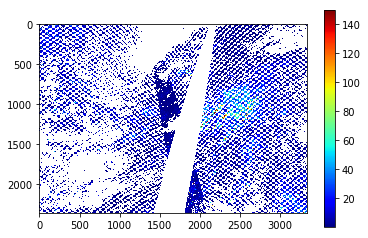

In [24]:
plt.imshow(test_array, cmap='jet')
plt.colorbar()

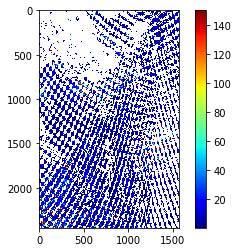

In [37]:
plt.imshow(test_array, cmap='jet')
plt.colorbar()

In [38]:
err_idx = np.where(test_array > 100.0)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [39]:
test_array[err_idx] = np.nan

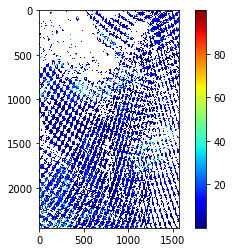

In [40]:
plt.imshow(test_array, cmap='jet')
plt.colorbar()

### Analysis program

In [25]:
def proc_sds(sds_array, variable='sds var'):
    """
    IN: array = hdf_data.select(variable_name)
    """
    array = sds_array.get()
    array = array.astype(np.float64)
    
    # nan process
    nan_idx = np.where( array == sds_array.attributes()['_FillValue'])
    if len(nan_idx) > 0:
        array[nan_idx] = np.nan
    else:
        pass
    
    # radiacne offset
    offset = sds_array.attributes()['add_offset']
    array = array - offset
    
    # radiance scale
    scales = sds_array.attributes()['scale_factor']
    array = array*scales
    
    ### Error Value process
    if variable == 'Cloud_Optical_Thickness':
        err_idx = np.where(array > 100.0) # optical thickness range[0,100] no unit
        array[err_idx] = np.nan
    
    return array

In [26]:
cot_hdf = SD(hdf_datadir+'/'+hdf_filelist[0], SDC.READ)
cwp_hdf = SD(hdf_datadir+'/'+hdf_filelist[1], SDC.READ)
cpi_hdf = SD(hdf_datadir+'/'+hdf_filelist[2], SDC.READ)
ctp_hdf = SD(hdf_datadir+'/'+hdf_filelist[3], SDC.READ)

In [27]:
cot_sds = cot_hdf.select("Cloud_Optical_Thickness")
cwp_sds = cwp_hdf.select("Cloud_Water_Path")
cpi_sds = cpi_hdf.select("Cloud_Phase_Infrared")
ctp_sds = ctp_hdf.select("Cloud_Top_Pressure")

In [28]:
cot_array = proc_sds(cot_sds, variable="Cloud_Optical_Thickness")
cwp_array = proc_sds(cwp_sds)
cpi_array = proc_sds(cpi_sds)
ctp_array = proc_sds(ctp_sds)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


In [29]:
nx, ny = cot_array.shape
d_list = [
    cot_array.reshape(nx,ny,1),
    cwp_array.reshape(nx,ny,1),
    cpi_array.reshape(nx,ny,1),
    ctp_array.reshape(nx,ny,1),
]

In [30]:
mod06_img = np.concatenate(d_list, axis=2)

In [31]:
mod06_img.shape

(2364, 3340, 4)

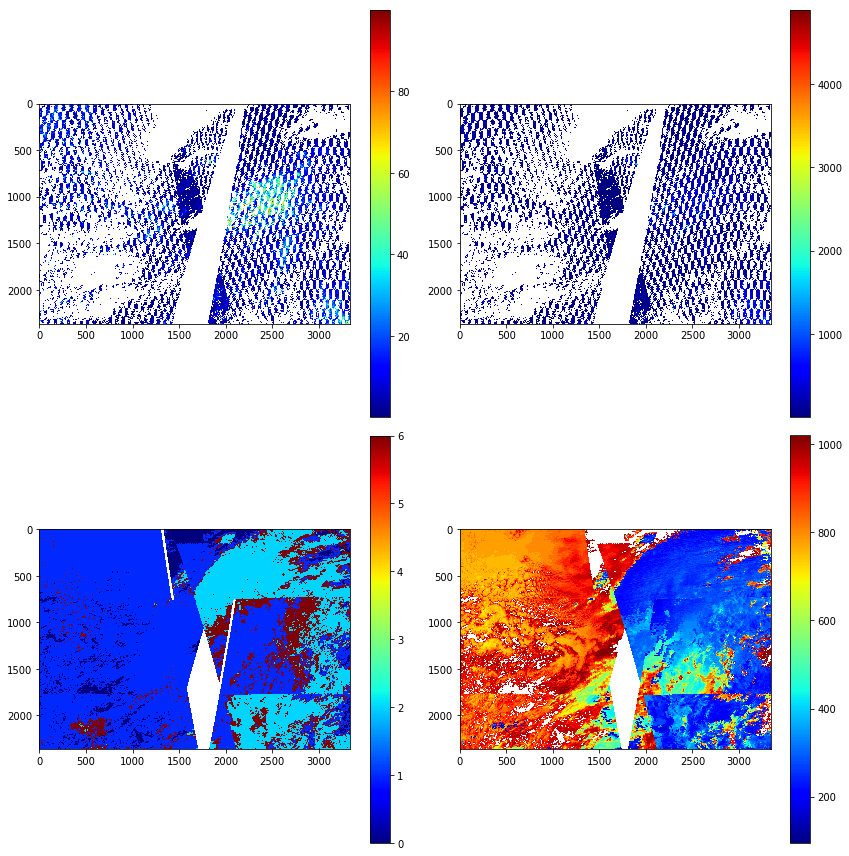

In [32]:
fig = plt.figure(figsize=(12,12))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(mod06_img[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

COT: 0 is optically transparent (no cloud) <-->100 is opticaly thick (can't see through). unit less  
CWP: measure of the weight of the liquid water droplets in the atmosphere above a unit surface area. (g/m^2)  
CPI: clear = 0; liquid water clouds = 1; ice clouds = 2; undetermined phase clouds = 6  
CTP: Pressure. hpa

### MODIS 02 data

In [57]:
hdf_datadir = "/project2/chard/clouds/data/MOD02/20020816"

In [58]:
hdf_filelist=[
    hdf_datadir+'/MOD021KM.A2002228.mosaic.061.2019127193327.mcgscs_000501333667.EV_500_Aggr1km_RefSB_4.hdf',
    hdf_datadir+'/MOD021KM.A2002228.mosaic.061.2019127193327.mcgscs_000501333667.EV_500_Aggr1km_RefSB_5.hdf',
    hdf_datadir+'/MOD021KM.A2002228.mosaic.061.2019127193327.mcgscs_000501333667.EV_1KM_Emissive_1.hdf',
    hdf_datadir+'/MOD021KM.A2002228.mosaic.061.2019127193327.mcgscs_000501333667.EV_1KM_Emissive_8.hdf',
    hdf_datadir+'/MOD021KM.A2002228.mosaic.061.2019127193327.mcgscs_000501333667.EV_1KM_Emissive_9.hdf',
    hdf_datadir+'/MOD021KM.A2002228.mosaic.061.2019127193327.mcgscs_000501333667.EV_1KM_Emissive_11.hdf'
]

In [61]:
### CheckOS
for ifile in hdf_filelist:
    print(os.path.exists(ifile))

True
True
True
True
True
True


In [62]:
def proc_sds(sds_array):
    """
    IN: array = hdf_data.select(variable_name)
    """
    array = sds_array.get()
    array = array.astype(np.float64)
    
    # check bandinfo
    _bands = sds_array.attributes()['band_names']
    print("Process bands", _bands)
    bands = _bands.split(",")
    
    # nan process
    nan_idx = np.where( array == sds_array.attributes()['_FillValue'])
    if len(nan_idx) > 0:
        array[nan_idx] = np.nan
    else:
        pass
    
    # radiacne offset
    offset = sds_array.attributes()['radiance_offsets']
    offset_array = np.zeros(array.shape) # new matrix
    offset_ones  = np.ones(array.shape)  # 1 Matrix 
    offset_array[:,:] = array[:,:] - offset*offset_ones[:,:]
    
    # radiance scale
    scales = sds_array.attributes()['radiance_scales']
    scales_array = np.zeros(array.shape) # new matrix
    scales_array[:,:] = scales*offset_array[:,:]
    return scales_array, bands

In [63]:
b6_hdf = SD(hdf_filelist[0], SDC.READ)
b7_hdf = SD(hdf_filelist[1], SDC.READ)
b20_hdf = SD(hdf_filelist[2], SDC.READ)
b28_hdf = SD(hdf_filelist[3], SDC.READ)
b29_hdf = SD(hdf_filelist[4], SDC.READ)
b31_hdf = SD(hdf_filelist[5], SDC.READ)

In [64]:
b6_sds = b6_hdf.select("EV_500_Aggr1km_RefSB")
b7_sds = b7_hdf.select("EV_500_Aggr1km_RefSB")
b20_sds = b20_hdf.select("EV_1KM_Emissive")
b28_sds = b28_hdf.select("EV_1KM_Emissive")
b29_sds = b29_hdf.select("EV_1KM_Emissive")
b31_sds = b31_hdf.select("EV_1KM_Emissive")

In [65]:
b6_array, b6 = proc_sds(b6_sds)
b7_array, b7 = proc_sds(b7_sds)
b20_array, b20 = proc_sds(b20_sds)
b28_array, b28 = proc_sds(b28_sds)
b29_array, b29 = proc_sds(b29_sds)
b31_array, b31 = proc_sds(b31_sds)

Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31


In [66]:
nx, ny = b6_array.shape
nx,ny

(2452, 1570)

In [67]:
d_list = [
    b6_array.reshape(nx,ny,1),
    b7_array.reshape(nx,ny,1),
    b20_array.reshape(nx,ny,1),
    b28_array.reshape(nx,ny,1),
    b29_array.reshape(nx,ny,1),
    b31_array.reshape(nx,ny,1),
]

In [68]:
mod02_img = np.concatenate(d_list, axis=2)

In [87]:
def const_array(patches):
    nx, ny = patches.shape[:2]
    patches_list = []
    xy_list = []
    for i in range(nx):
        for j in range(ny):
            if not np.isnan(patches[i,j]).any():
                patches_list += [patches[i,j]]
                xy_list += [(i,j)]
    return patches_list, xy_list

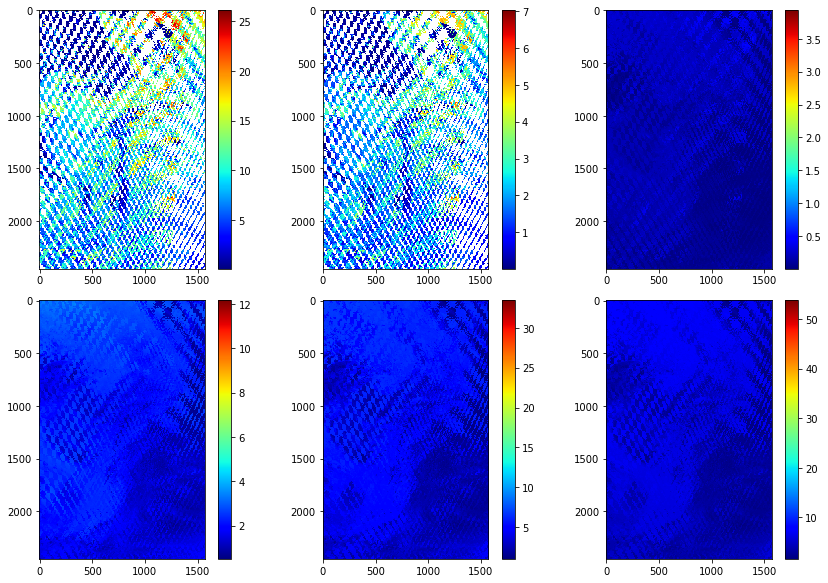

In [94]:
fig = plt.figure(figsize=(12,12))
for idx, i in enumerate(range(6)):
    ax = plt.subplot(3,3,idx+1)
    plt.imshow(mod02_img[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

### Interpolation

In [96]:
df =  pd.DataFrame(b6_array.reshape(nx,ny))

In [98]:
_df = df.interpolate()

In [100]:
int_b6_array = _df.to_numpy()

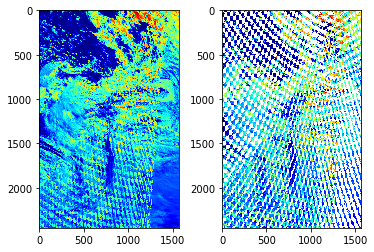

In [102]:
fig = plt.figure()
ax = plt.subplot(121)
plt.imshow(int_b6_array, cmap='jet')
ax = plt.subplot(122)
plt.imshow(b6_array, cmap='jet')

### Compare clustering and modis06

#### Clustering

In [84]:
patches = _gen_patches(mod02_img, normalization=False)
patches.shape

(19, 12, 128, 128, 6)

In [88]:
patches_list, xy_list = const_array(patches) # remove patches with np.nan include

In [92]:
xy_list

[]

In [81]:
encs_list = []
for i in patches_list:
    encs = encoder.predict(i.reshape(1,128,128,6))
    encs_list += [encs.mean(axis=(1,2))]

In [82]:
features = np.concatenate(encs_list, axis=0)

ValueError: need at least one array to concatenate

In [74]:
ix, iy = patches.shape[:2]
fig = plt.figure(figsize=(14,14))
for jdx, n_cluster in enumerate(range(4,22,2)):
    method = AgglomerativeClustering(n_clusters=n_cluster)
    _patches_labels = method.fit_predict(features)
    img_array = np.zeros((ix,iy)).astype(np.float64)
    img_array[:,:] = np.nan
    for idx, (x,y) in enumerate(xy_list):
        img_array[x,y] = _patches_labels[idx]
    ax = plt.subplot(3,3,jdx+1)
    plt.imshow(img_array, cmap='jet')
    ax.set_title(" #Cluster % d" % n_cluster)
    plt.colorbar(orientation='horizontal')
fig.tight_layout()
plt.show()

NameError: name 'features' is not defined

<Figure size 1008x1008 with 0 Axes>

#### Distribution

In [69]:
mod06_patches = _gen_patches(mod06_img, normalization=False, flag_nan=True)

In [70]:
mod06_patches.shape

(35, 37, 128, 128, 4)

In [71]:
mod06_patches_mean = np.nanmean(mod06_patches, axis=(2,3))

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [127]:
prep_phase = copy.deepcopy(mod06_patches[:,:,:,:,2])

In [138]:
prep_phase.shape

(35, 37, 128, 128)

In [136]:
prep_phase[0,0].shape

(128, 128)

In [139]:
_x, _y = mod06_patches.shape[:2]
phase_mode = np.zeros((_x,_y))
for i in range(_x):
    for j in range(_y):
        phase, _= sc.stats.mode(prep_phase[i,j].flatten(), nan_policy='propagate')
        phase_mode[i,j] = phase

In [141]:
mod06_patches_mean[:,:,2] = phase_mode

In [142]:
mod06_patches_mean.shape

(35, 37, 4)

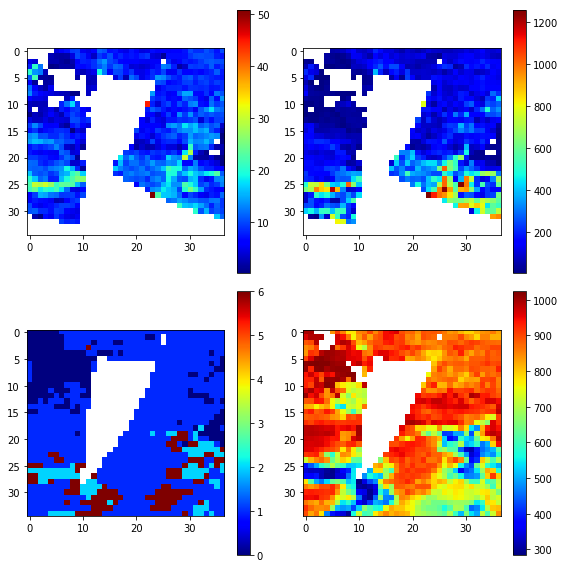

In [143]:
fig = plt.figure(figsize=(8,8))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(mod06_patches_mean[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

### Cluster 12

In [74]:
for n_cluster in [12]:
    method = AgglomerativeClustering(n_clusters=n_cluster)
    _patches_labels = method.fit_predict(features)
    img_array = np.zeros((ix,iy)).astype(np.float64)
    img_array[:,:] = np.nan
    for idx, (x,y) in enumerate(xy_list):
        img_array[x,y] = _patches_labels[idx]

In [105]:
patches_mean = np.nanmean(patches, axis=(1,2))

In [144]:
intensity = []
physics = []
for icluster in range(n_cluster):
    # get index
    cluster_idx = np.where(img_array == icluster)
    
    #image intensity
    intensity +=[patches_mean[cluster_idx]]
    
    # physics properties
    physics += [mod06_patches_mean[cluster_idx]]

In [107]:
intensity[0].shape

(49, 6)

#### Intensity Distribution

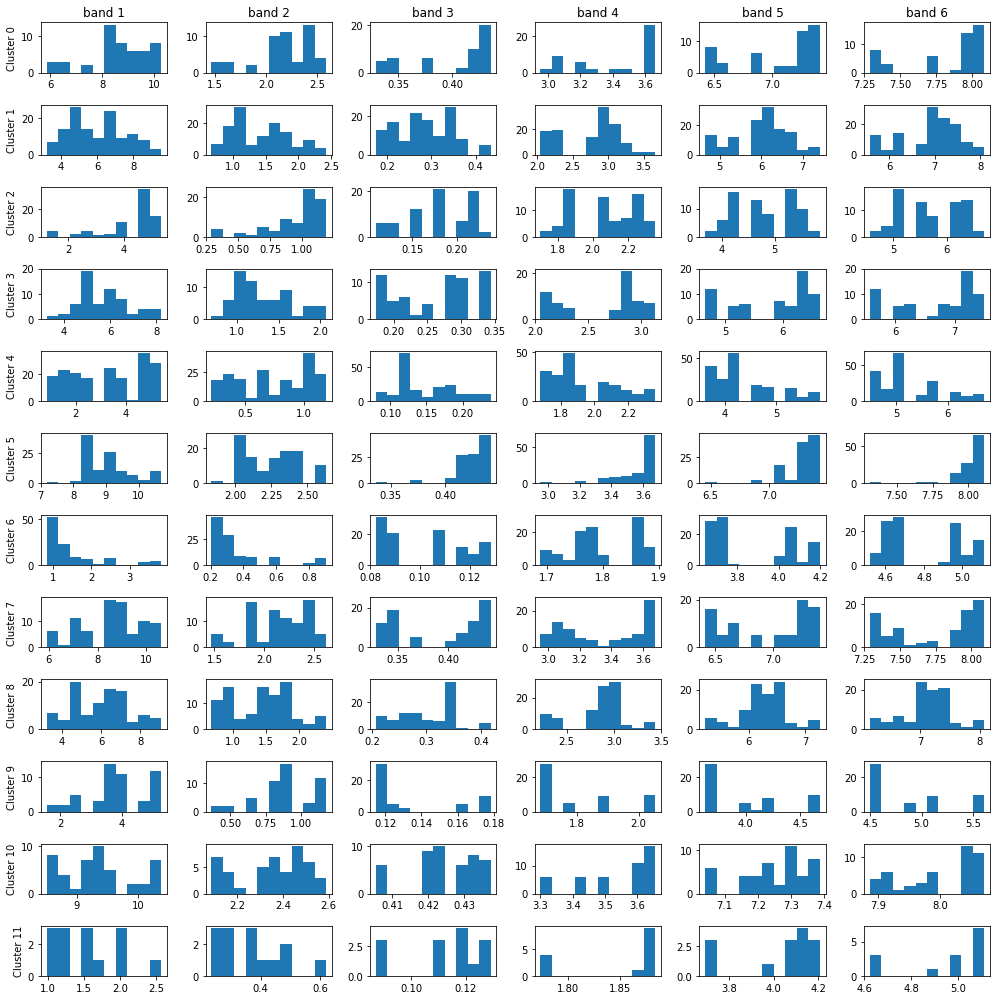

In [108]:
fig = plt.figure(figsize=(14,14))
it = 1
for i in range(n_cluster):
    for k in range(6):
        ax = plt.subplot(n_cluster, 6, it)
        plt.hist(intensity[i][:,k])
        if i == 0:
            ax.set_title("band %d" % (k+1))   
        if k == 0:
            ax.set_ylabel("Cluster %d" % i)
        it += 1
fig.tight_layout()
plt.show()

#### Physics Distribution

In [109]:
namelist = [
    "Optical Thickness",
    "Cloud Water Path",
    "Phase",
    "Cloud Top Pressure"
]

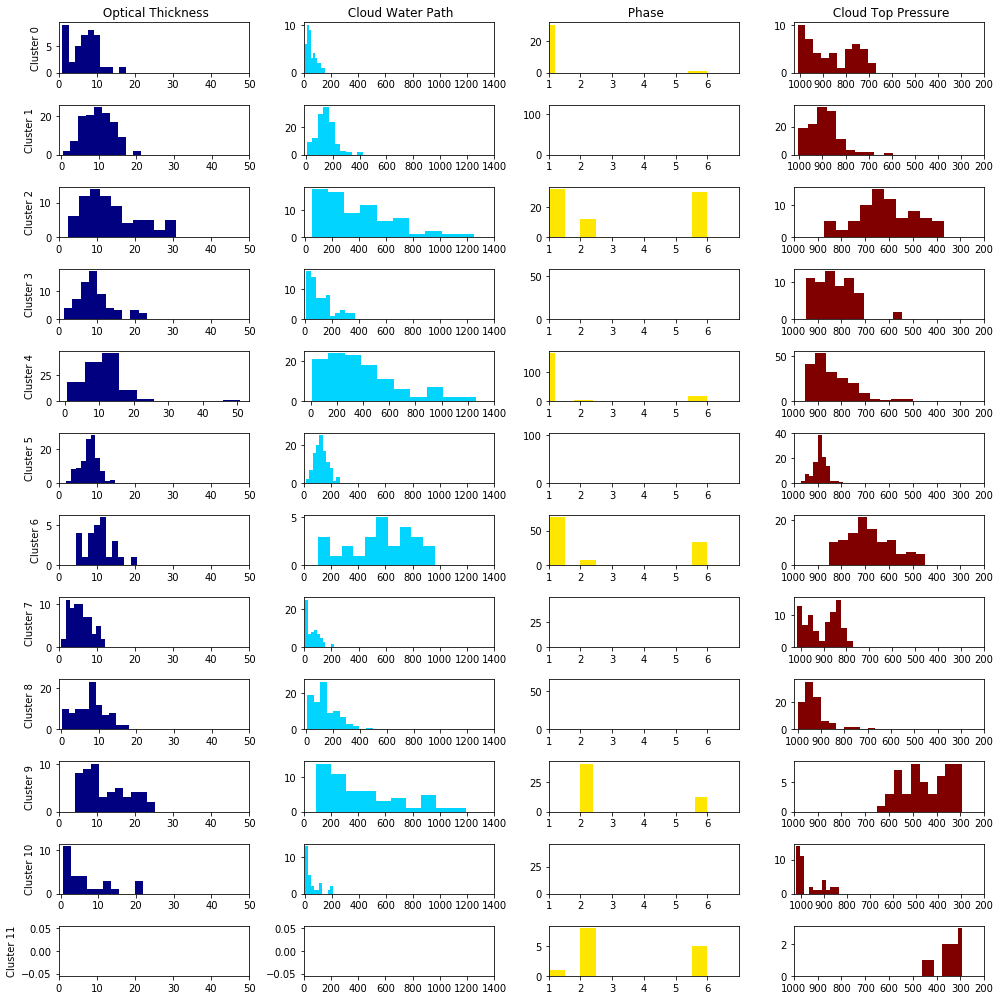

In [146]:
fig = plt.figure(figsize=(14,14))
it = 1
phys_colors = _get_colors(n=4)
for i in range(n_cluster):
    for k in range(4):
        ax = plt.subplot(n_cluster, 4, it)
        tmp = physics[i][:,k]
        tmp = tmp[np.logical_not(np.isnan(tmp))]
        plt.hist(tmp, color=phys_colors[k])
        if i == 0:
            ax.set_title(" %s" % namelist[k])   
        if k == 0:
            ax.set_ylabel("Cluster %d" % i)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            ax.set_xticks([l for l in range(0,1500,200)])
        elif k == 2:
            ax.set_xticks([l for l in range(1,7,1)])
            ax.set_xlim(1,7)
        elif k ==3:
            ax.set_xticks([l for l in range(200,1001,100)])
            ax.invert_xaxis()
        it += 1
fig.tight_layout()
plt.show()

### Visual check

In [130]:
vis_file = hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_250_Aggr1km_RefSB_1.hdf'
vhdf = SD(vis_file, SDC.READ)
vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")
vhdf_array, vis_band = proc_sds(vhdf_sds)

Process bands 1


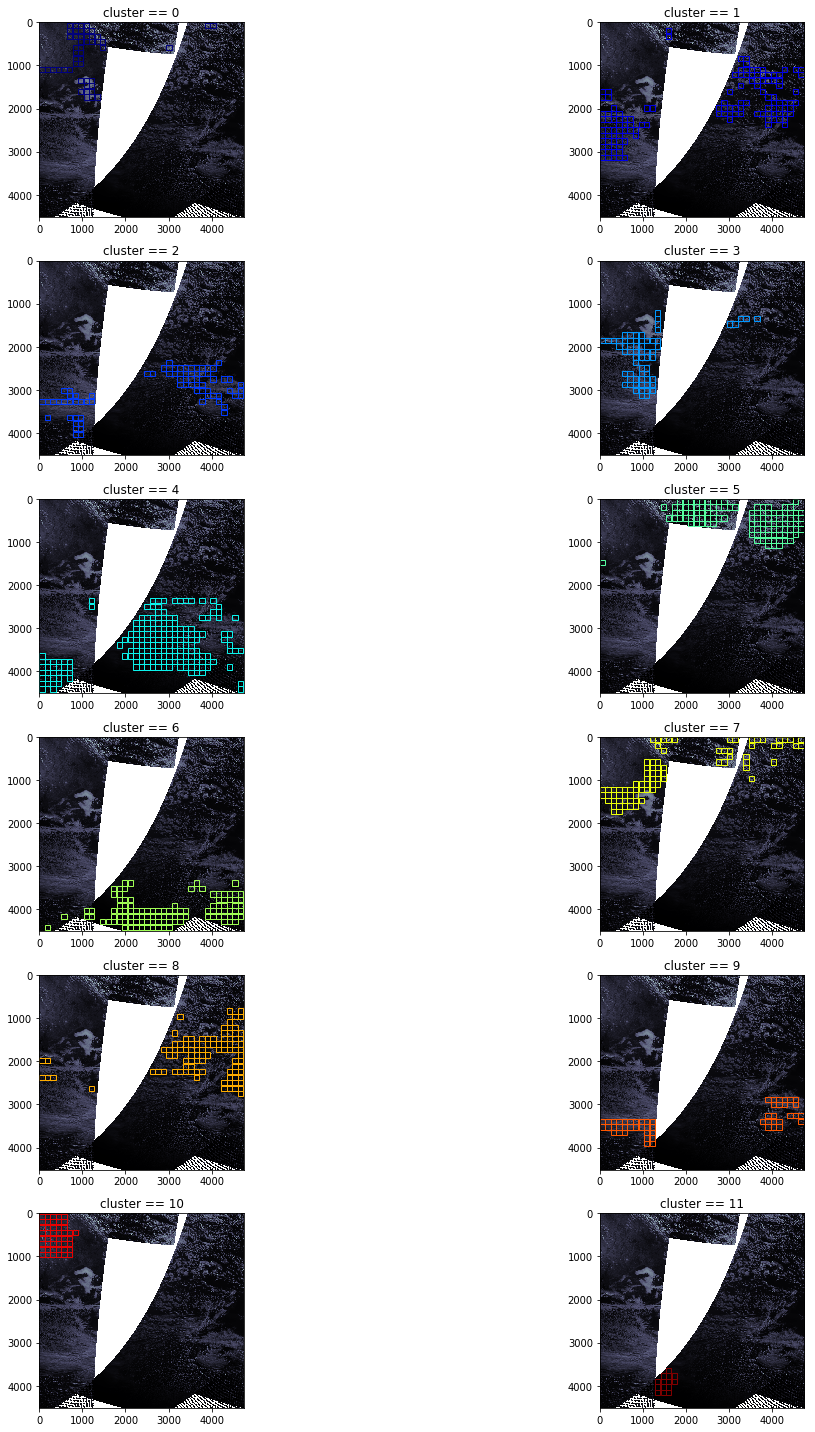

In [147]:
fig = plt.figure(figsize=(20,20))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_cluster)
for idx, icluster in enumerate(range(12)):
    ax = plt.subplot(6,2,idx+1)
    plt.imshow(vhdf_array, cmap='bone')
    ax.set_title("cluster == %d" % idx)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if not np.isnan(img_array[i,j]):
                if img_array[i,j] == icluster:
                    ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()